# dlt pipeline

### 🧩 Welcome

In this notebook we will walkthrough how to use dlt to prepare data
for an anomaly detection model training task.

We will simulate the real-world-scenario that is described in greater detail
in the [README](README.md) file.

A quick reminder: Our goal is to combine scattered and unstructured image data into a clean and normalized
database. To do so we will use dlt and duckDB.

Additionally, our datasets will be:
- MVTechAD
- DAGM 2007

What makes this close to the original problem is the different structure of both datasets, as well as their differing image sizes.

### ✈ Necessary Imports

In [ ]:
import numpy as np
from auxiliary import show_sample_images, run_pipeline
import os
import glob
from PIL import Image
import io
import pandas as pd


# To show the directory tree without custom code
!pip install directory_tree

# For the pipeline
!pip install dlt

# For the database support
!pip install "dlt[duckdb]"

### 🖼️ Dataset visualization

First, lets familiarize ourselves with the data.

Image size:  (512, 512)


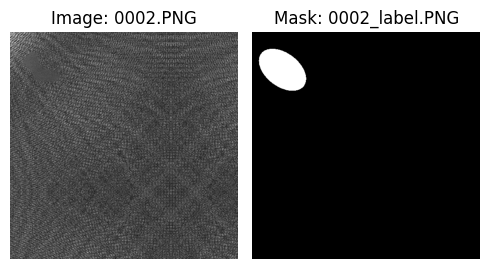

Image size:  (900, 900)


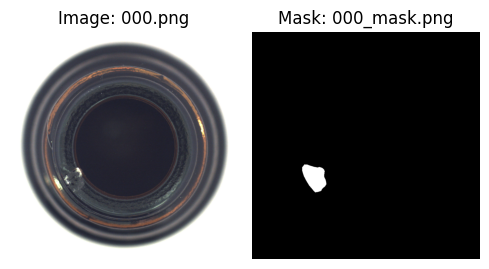

In [2]:
# DAGM data
show_sample_images("data", dataset="dagm_excerpt", category="Class1", n=1)

# MVTEC data
show_sample_images("data", dataset="mvtec_excerpt", category="bottle", n=1)

As we can see the images have different dimensions.
A characteristic that needs to be normalized before we can continue with model training.

Now lets look at the structure of the directory trees to reveal another inbalance.

In [3]:
from directory_tree import display_tree

display_tree("data/dagm_excerpt/")

dagm_excerpt/
└── Class1/
    ├── Test/
    │   ├── 0002.PNG
    │   ├── 0010.PNG
    │   ├── 0021.PNG
    │   ├── 0027.PNG
    │   ├── 0032.PNG
    │   ├── 0035.PNG
    │   ├── 0041.PNG
    │   ├── 0043.PNG
    │   ├── 0048.PNG
    │   ├── 0060.PNG
    │   └── Label/
    │       ├── 0002_label.PNG
    │       ├── 0010_label.PNG
    │       ├── 0021_label.PNG
    │       ├── 0027_label.PNG
    │       ├── 0032_label.PNG
    │       ├── 0035_label.PNG
    │       ├── 0041_label.PNG
    │       ├── 0043_label.PNG
    │       ├── 0048_label.PNG
    │       └── 0060_label.PNG
    └── Train/
        ├── 0576.PNG
        ├── 0577.PNG
        ├── 0578.PNG
        ├── 0579.PNG
        ├── 0580.PNG
        ├── 0581.PNG
        ├── 0582.PNG
        ├── 0583.PNG
        ├── 0584.PNG
        └── 0585.PNG


/var/folders/m0/ny3lzcdj38zdn1rc74ts0y1w0000gn/T/ipykernel_68694/1166682574.py:3: DeprecationWarning: The `display_tree` Function is Deprecated and will be Removed in a Future Release. Please use `DirectoryTree` Instead. End of Life Date is "31st December 2024".
  display_tree("data/dagm_excerpt/")


In [4]:
display_tree("data/mvtec_excerpt/")

mvtec_excerpt/
└── bottle/
    ├── ground_truth/
    │   ├── 000_mask.png
    │   ├── 001_mask.png
    │   ├── 002_mask.png
    │   ├── 003_mask.png
    │   ├── 004_mask.png
    │   ├── 005_mask.png
    │   ├── 006_mask.png
    │   ├── 007_mask.png
    │   ├── 008_mask.png
    │   └── 009_mask.png
    ├── test/
    │   ├── 000.png
    │   ├── 001.png
    │   ├── 002.png
    │   ├── 003.png
    │   ├── 004.png
    │   ├── 005.png
    │   ├── 006.png
    │   ├── 007.png
    │   ├── 008.png
    │   └── 009.png
    └── train/
        ├── 016.png
        ├── 043.png
        ├── 058.png
        ├── 066.png
        ├── 077.png
        ├── 101.png
        ├── 136.png
        ├── 173.png
        ├── 191.png
        └── 208.png


/var/folders/m0/ny3lzcdj38zdn1rc74ts0y1w0000gn/T/ipykernel_68694/3213554374.py:1: DeprecationWarning: The `display_tree` Function is Deprecated and will be Removed in a Future Release. Please use `DirectoryTree` Instead. End of Life Date is "31st December 2024".
  display_tree("data/mvtec_excerpt/")


We can notice that there is no uniform structure in how data is stored at the moment.
This will require proprietary normalization algorithms.

A way better approach would be to normalize the data by size and structure.
Additionally, it should be made available for everyone coming from one source.

To do so we will use dlt and duckDB! 🎉

In [2]:
# Before performing this line of code delete the uniform_images.duckdb file or skip this step
pipeline = run_pipeline("data/mvtec_excerpt/", "data/dagm_excerpt/")

Found 30 images in data/mvtec_excerpt/
Found 30 images in data/dagm_excerpt/
Pipeline info: Pipeline uniform_images load step completed in 0.14 seconds
1 load package(s) were loaded to destination duckdb and into dataset image_dataset
The duckdb destination used duckdb:////Users/michaelsamjatin/repos/dltHub-assessment/uniform_images.duckdb location to store data
Load package 1744764201.694328 is LOADED and contains no failed jobs


After running our pipeline, we can see a .duckdb [file](uniform_images.duckdb).
We can query it to look at the results.

In [3]:
import duckdb

# Connect to the DuckDB created by dlt
conn = duckdb.connect("uniform_images.duckdb")

# Query the data
result_v1 = conn.execute("""
    SELECT dataset, class, split, COUNT(*) as count 
    FROM image_dataset.images
    GROUP BY dataset, class, split
""").fetchall()


result_v2 = conn.execute("""
    SELECT 
        filename, 
        dataset, 
        class, 
        split,
        image_size
    FROM image_dataset.images
    ORDER BY RANDOM()
    LIMIT 5;
""").fetchall()



print(result_v1)
print(result_v2)

[('mvtec', 'bottle', 'train', 10), ('dagm', 'Class1', 'train', 10), ('dagm', 'Class1', 'test', 20), ('mvtec', 'bottle', 'ground_truth', 10), ('mvtec', 'bottle', 'test', 10)]
[('0035_label.PNG', 'dagm', 'Class1', 'test', '256x256'), ('173.png', 'mvtec', 'bottle', 'train', '256x256'), ('006_mask.png', 'mvtec', 'bottle', 'ground_truth', '256x256'), ('0585.PNG', 'dagm', 'Class1', 'train', '256x256'), ('008_mask.png', 'mvtec', 'bottle', 'ground_truth', '256x256')]


We observe, that we have normalized image sizes in the database and have created a uniform structure.

With the values in the database, we can plug them into our model training in the next step.

#### TODO: Intialize model and start training / evaluation